# Energy A.I. Hackathon 2024 Workflow - Tigris Mendez

This project was done after the Hackathon event a learning exercise, referencing my team's project and the winning teams project.

## Executive Summary



1.   Our task was to predict the Average Pump Difference using features given in a dataset.
2.   Most important features we choosen with XGBoost's important() method
3.   We learned how important domain expertise can be and how simple a simple model can reveal alot about a small dataset.
4.   





---

##Goal
Predict Average Pump Difference accurately with the given data



---



##Workflow

1. Data Preprocessing
2. Feature Selection
3. Imputation
4. Model Selection
5. Uncertainty Model



#Import Packages

In [17]:
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

##Read-in Hackathon Dataset

In [18]:
df = pd.read_csv('/content/HackathonData2024.csv')

In [19]:
df.head()

,Well ID,Avg Pump Difference,Area,Lateral Length,Fluid System,TVD,Development Strategy,DELAYED,BOUND_CODE,CODEV_POSITION,...,CODEV_3000_AVG_TVD_DIST,CODEV_3000_AVG_WELL_AGE,CODEV_3000_MEDIAN_WELL_AGE,CODEV_3000_WELL_COUNT,Pressure Gradient (psi/ft) new,Soak Time,Avg Open Pressure,SD Open Pressure,Avg Close Pressure,SD Close Pressure
0,1,-0.93,Acadia,10300,Campbell,10415.0,Coke,1,11100000,Edge,...,4,0.0,0.0,1,0.593758,34,3304.124833,261.7,2719.898438,472.4
1,2,-8.45,Acadia,10300,Campbell,10415.0,Coke,1,11100000,Edge,...,4,0.0,0.0,1,0.597059,67,3301.199254,255.9,2934.885325,747.4
2,3,8.70,Arches,11000,Campbell,8470.0,Orange Crush,0,101111,Middle,...,682,4.5,0.0,11,0.516873,34,2774.407080,184.8,1589.948673,596.9
3,4,NaN,Arches,11000,Campbell,10555.0,Coke,1,11110000,Edge,...,4,0.0,0.0,1,0.501287,30,2653.539415,206.7,1304.162878,551.5
4,5,19.93,Badlands,2300,Campbell,9295.0,Mountain Dew,1,10001101,Edge,...,277,1.0,1.0,2,0.503327,336,NaN,NaN,NaN,NaN


####Runing a type check to make sure all variables are types we can perform analysis on.

In [20]:
column_data_types = {}

for column in df.columns:
    data_type = df[column].dtype
    column_data_types[column] = str(data_type)

print("Column Data Types:")

for column, data_type in column_data_types.items():
    print(f"{column}: {data_type}")

Column Data Types:
Well ID: int64
Avg Pump Difference: float64
Area: object
Lateral Length: int64
Fluid System: object
TVD: float64
Development Strategy: object
DELAYED: int64
BOUND_CODE: int64
CODEV_POSITION: object
CODEV_FORMATION_POSITION: object
PARENT_CODEV_1050_WELL_COUNT: int64
PARENT_IN_ZONE_MIN_HYPOT: float64
PARENT_OUT_ZONE_MIN_HYPOT: float64
PARENT_IN_ZONE_MIN_MAP_DIST: float64
PARENT_OUT_ZONE_MIN_MAP_DIST: float64
PARENT_1050_AVG_WELL_AGE: float64
PARENT_1050_MEDIAN_WELL_AGE: float64
PARENT_1050_WELL_COUNT: int64
PARENT_3000_AVG_HYPOT_DIST: float64
PARENT_3000_AVG_MAP_DIST: float64
PARENT_3000_AVG_TVD_DIST: float64
PARENT_3000_AVG_WELL_AGE: float64
PARENT_3000_MEDIAN_WELL_AGE: float64
PARENT_3000_WELL_COUNT: int64
CODEV_IN_ZONE_MIN_HYPOT: float64
CODEV_OUT_ZONE_MIN_HYPOT: float64
CODEV_IN_ZONE_MIN_MAP_DIST: float64
CODEV_1050_WELL_COUNT: int64
CODEV_3000_AVG_HYPOT_DIST: int64
CODEV_3000_AVG_MAP_DIST: int64
CODEV_3000_AVG_TVD_DIST: int64
CODEV_3000_AVG_WELL_AGE: float64
CODE

# Data Preprocessing

####Drop ID and Response var

*Because this data has categorical and numerical data types, we will one-hot encode the data to make them one-hot vectors. This will make all of the data numerical.*




**Our Categorical features are the following:**





In [21]:
# categorical_variables = df.select_dtypes(include='object').columns.tolist()

# print("Categorical Variable Names:")
# for var in categorical_variables:
#     print(var)

In [22]:
categorical_columns = ["Area", "Fluid System", "Development Strategy", "CODEV_POSITION", "CODEV_FORMATION_POSITION"]
one_hot_df = pd.concat([df] + [pd.get_dummies(df[col], drop_first = True) for col in categorical_columns], axis=1).drop(columns=categorical_columns)

####'BOUND_CODE' :

The Hackathon organizers gave us a description of the feature named 'BOUND_CODE' which desibes the area plot around a well and whether a well exist in that area or not. Because of this unique data type, it was important to maintain the information present by one-hot encoding converting each BOUND into a seperate section variable.

In [23]:
# Bound code zone:
#
#  +---+---+---+
#  | 1 | 2 | 3 |
#  +---+---+---+
#  | 4 |   | 5 |
#  +---+---+---+
#  | 6 | 7 | 8 |
#  +---+---+---+
#
#  Example BOUND_CODE : 11100000

*This code chunk below was from the winning team: "BevoBaddies"*






In [24]:
out = []

for k, code in enumerate(df['BOUND_CODE']):
  code_str = str(code).rjust(8, '0')
  tmp = []
  for i in range(8):
    tmp.append(int(code_str[i]))
  out.append(tmp)

out = np.transpose(out)

for i in range(len(out)):
  one_hot_df[f'BOUND_CODE_{i}'] = pd.Series(out[i])

# Now we do not need the BOUND_CODE column

one_hot_df = df.drop(columns=["BOUND_CODE"])

starting_features = df.drop(columns=["Avg Pump Difference", "Well ID"])
y = df["Avg Pump Difference"]



*   We will drop Well ID because it is not a feature here
*   We will drop Avg Pump Difference because it is our response variable





---



##Data Imputation

####Data Incompleteness
Our data has some missing values, we want to know how much.

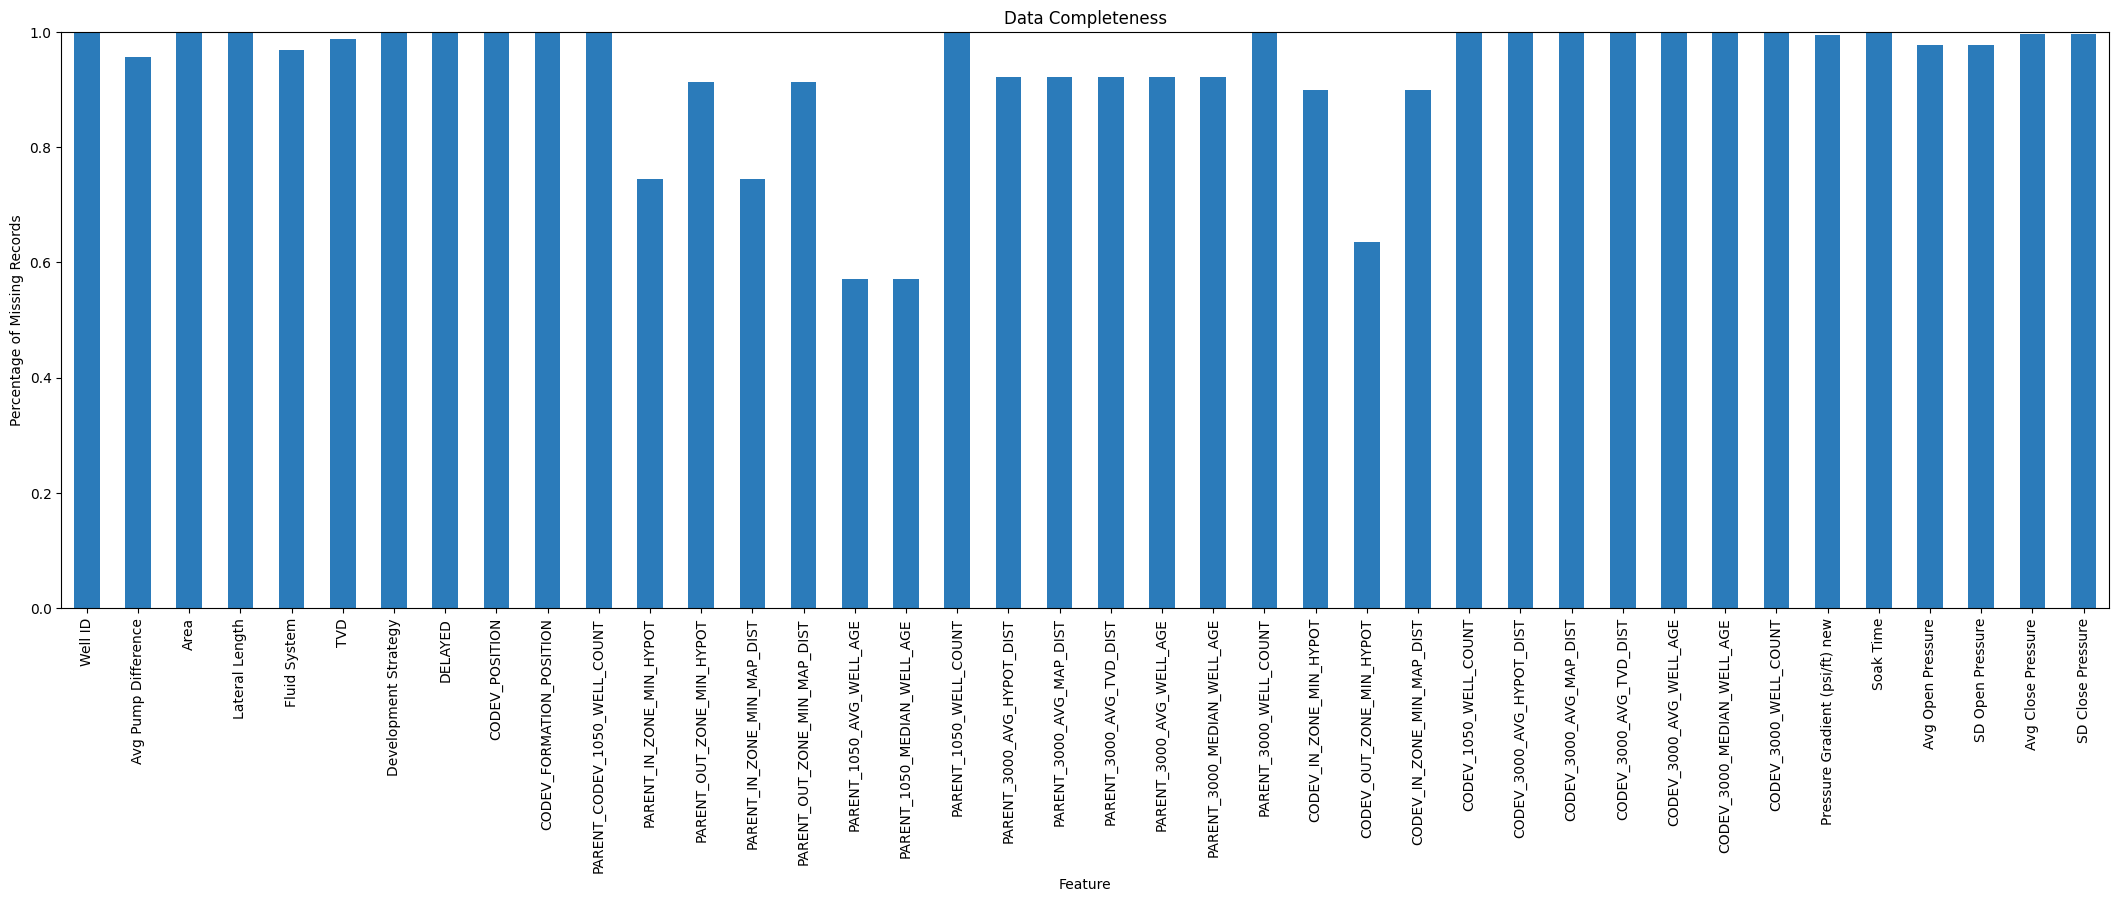

In [25]:
df_completeness = 1 - one_hot_df.isnull().sum() / len(one_hot_df)

# Plotting
blue_color = sns.color_palette("Blues")[4]  # You can adjust the index to choose a different shade of blue
df_completeness.plot(kind='bar', color=blue_color)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2)  # plot formatting
plt.xlabel('Feature')
plt.ylabel('Percentage of Missing Records')
plt.title('Data Completeness')
plt.ylim([0, 1.0])
plt.show()

###Should we remove the data incomplete features?
> Removing features could potentially remove valuable information during analysis, so we decided to perform EDA on the Five variables:


*   CODEV_OUT_ZONE_MIN_HYPOT
*   PARENT_1050_MEDIAN_WELL_AGE
*   PARENT_1050_AVG_WELL_AGE
*   PARENT_IN_ZONE_MIN_MAP_DIST
*   PARENT_IN_ZONE_MIN_HYPOT

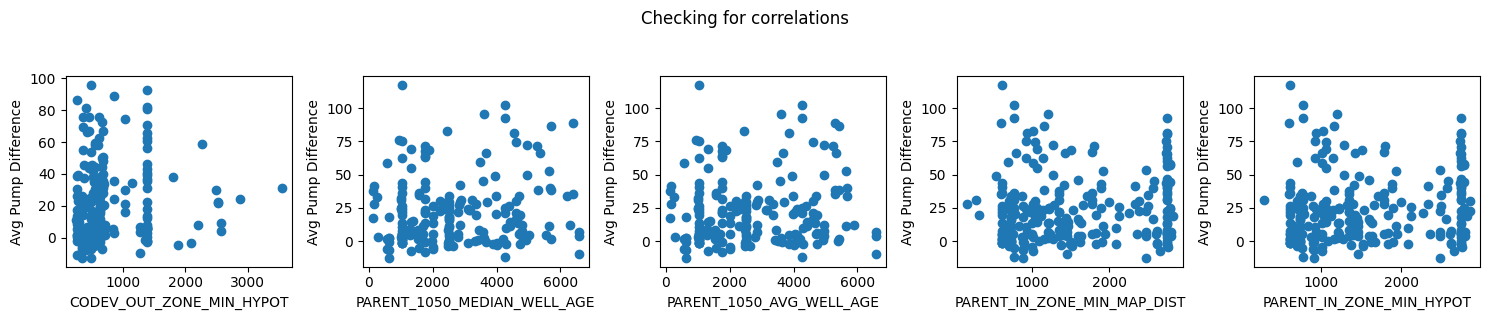

In [26]:
# Variables
variables = ['CODEV_OUT_ZONE_MIN_HYPOT', 'PARENT_1050_MEDIAN_WELL_AGE',
             'PARENT_1050_AVG_WELL_AGE', 'PARENT_IN_ZONE_MIN_MAP_DIST',
             'PARENT_IN_ZONE_MIN_HYPOT']

# Create a figure and subplots
fig, axs = plt.subplots(1, len(variables), figsize=(15, 3), sharey=False)

# Loop through variables and create subplots
for i, variable in enumerate(variables):
    axs[i].scatter(one_hot_df[variable], one_hot_df['Avg Pump Difference'])
    axs[i].set_xlabel(variable)
    axs[i].set_ylabel('Avg Pump Difference')

# Add a common title to the entire figure
fig.suptitle('Checking for correlations', y=1.05)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Display the plot
plt.show()


## Data Imputation

> I did find anything significant regarding their relation. Perhaps performing data imputation will change that?

I will be using the ***K-Nearest Neighborhood*** method to perform data imputation



In [27]:
starting_features.head(n=15)

,Area,Lateral Length,Fluid System,TVD,Development Strategy,DELAYED,BOUND_CODE,CODEV_POSITION,CODEV_FORMATION_POSITION,PARENT_CODEV_1050_WELL_COUNT,...,CODEV_3000_AVG_TVD_DIST,CODEV_3000_AVG_WELL_AGE,CODEV_3000_MEDIAN_WELL_AGE,CODEV_3000_WELL_COUNT,Pressure Gradient (psi/ft) new,Soak Time,Avg Open Pressure,SD Open Pressure,Avg Close Pressure,SD Close Pressure
0,Acadia,10300,Campbell,10415.0,Coke,1,11100000,Edge,Edge,2,...,4,0.0,0.0,1,0.593758,34,3304.124833,261.7,2719.898438,472.4
1,Acadia,10300,Campbell,10415.0,Coke,1,11100000,Edge,Edge,2,...,4,0.0,0.0,1,0.597059,67,3301.199254,255.9,2934.885325,747.4
2,Arches,11000,Campbell,8470.0,Orange Crush,0,101111,Middle,Edge,6,...,682,4.5,0.0,11,0.516873,34,2774.407080,184.8,1589.948673,596.9
3,Arches,11000,Campbell,10555.0,Coke,1,11110000,Edge,Edge,1,...,4,0.0,0.0,1,0.501287,30,2653.539415,206.7,1304.162878,551.5
4,Badlands,2300,Campbell,9295.0,Mountain Dew,1,10001101,Edge,Edge,4,...,277,1.0,1.0,2,0.503327,336,NaN,NaN,NaN,NaN
5,Big Bend,12300,Campbell,10355.0,Coke,1,11110000,Edge,Edge,0,...,1410,21.5,28.5,4,0.565200,21,2963.567911,232.0,2063.408619,517.8
6,Big Bend,12600,Campbell,8120.0,Orange Crush,1,10101111,Edge,Edge,4,...,177,-0.7,-1.0,3,0.561294,34,2814.617107,296.9,2330.939138,471.2
7,Arches,11000,Campbell,10560.0,Coke,1,11111000,Edge,Edge,2,...,29,-0.5,-0.5,2,0.493534,135,2697.576560,222.9,1975.744979,707.7
8,Big Bend,12900,Campbell,10345.0,Coke,1,11111000,Edge,Edge,1,...,36,0.0,0.0,1,0.560111,227,2892.427934,248.5,2235.448950,698.1
9,Canyonlands,10000,Campbell,8335.0,Mountain Dew,0,10001001,Middle,Middle,2,...,21,7.1,16.0,7,0.540762,21,2763.612613,159.2,1671.514259,287.2


In [28]:
# df_imputated = df[["PARENT_IN_ZONE_MIN_MAP_DIST", "PARENT_1050_MEDIAN_WELL_AGE", "PARENT_1050_WELL_COUNT",
#                   "PARENT_3000_AVG_MAP_DIST", "PARENT_3000_MEDIAN_WELL_AGE", "PARENT_3000_WELL_COUNT",
#                   "Pressure Gradient (psi/ft) new", "Lateral Length", "TVD", "Soak Time", "Avg Pump Difference"]]

# df_imputated["Imputed"] = (df_imputated.isnull().sum(axis=1)) > 0
# df_imputated.head()

NameError: name 'df_knn' is not defined

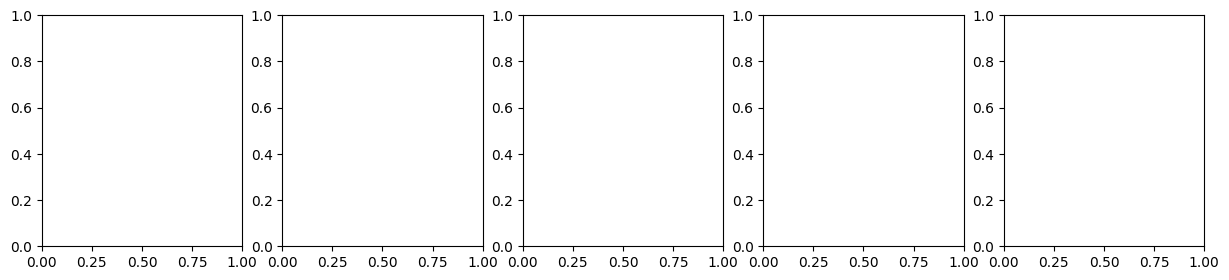

In [29]:
# Variables
variables = ['CODEV_OUT_ZONE_MIN_HYPOT', 'PARENT_1050_MEDIAN_WELL_AGE',
             'PARENT_1050_AVG_WELL_AGE', 'PARENT_IN_ZONE_MIN_MAP_DIST',
             'PARENT_IN_ZONE_MIN_HYPOT']

# Create a figure and subplots
fig, axs = plt.subplots(1, len(variables), figsize=(15, 3), sharey=False)

# Loop through variables and create subplots
for i, variable in enumerate(variables):
    axs[i].scatter(df_knn[variable], df_knn['Avg Pump Difference'])
    axs[i].set_xlabel(variable)
    axs[i].set_ylabel('Avg Pump Difference')

# Add a common title to the entire figure
fig.suptitle('Checking for correlations', y=1.05)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df_completeness = 1 - df_knn.isnull().sum() / len(df_knn)

# Plotting
blue_color = sns.color_palette("Blues")[4]  # You can adjust the index to choose a different shade of blue
df_completeness.plot(kind='bar', color=blue_color)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2)  # plot formatting
plt.xlabel('Feature')
plt.ylabel('Percentage of Missing Records')
plt.title('Data Completeness')
plt.ylim([0, 1.0])
plt.show()

## Feature Selection

## Collinearity heatmap
A collinearity heatmap informs us which independent variables move in relation to one another. For our numerical values, it is imperitive that we perform a collinearity. Yet, because we one-hot encoded our cateogrical data, we don't need to worry about it.